# 1. Import Libraries and Load Models

In [11]:
import torch
import torch.nn as nn
import torchvision
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import os
import timm


# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load datasets
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_dir = 'output_dataset/test'
test_dataset = ImageFolder(root=test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# Load models
def load_model(model_path, model_type):
    if model_type == 'resnet18':
        model = models.resnet18(pretrained=False)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, 4)
    elif model_type == 'efficientnetv2':
        model = models.efficientnet_v2_s(pretrained=False)
        num_ftrs = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_ftrs, 4)
    elif model_type == 'swin_t':
        model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=False, num_classes=4)

    # Load the state dictionary
    state_dict = torch.load(model_path)

    # Fix key mismatches for Swin Transformer models
    if model_type == 'swin_t':
        new_state_dict = {}
        for key, value in state_dict.items():
            if key == "head.weight": 
                new_state_dict["head.fc.weight"] = value
            elif key == "head.bias": 
                new_state_dict["head.fc.bias"] = value
            else:
                new_state_dict[key] = value 

        model.load_state_dict(new_state_dict, strict=False)  # Allow slight mismatch
    else:
        model.load_state_dict(state_dict)

    model = model.to(device)
    return model

resnet18_baseline = load_model('resnet18_baseline.pth', 'resnet18')
resnet18_pruned = load_model('resnet18_pruned.pth', 'resnet18')
efficientnetv2_baseline = load_model('efficientnetv2_baseline.pth', 'efficientnetv2')
efficientnetv2_pruned = load_model('efficientnetv2_pruned.pth', 'efficientnetv2')
swin_t_baseline = load_model('swin_t_baseline.pth', 'swin_t')
swin_t_pruned = load_model('swin_t_pruned.pth', 'swin_t')


c:\Users\shash\OneDrive\Desktop\ai-and-sus\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\shash\OneDrive\Desktop\ai-and-sus\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


# 2. Evaluate Model Performance

In [ ]:
#Evaluate the performance of each model on the test dataset.
def evaluate_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

models = {
    'ResNet18 Baseline': resnet18_baseline,
    'ResNet18 Pruned': resnet18_pruned,
    'EfficientNetV2 Baseline': efficientnetv2_baseline,
    'EfficientNetV2 Pruned': efficientnetv2_pruned,
    'Swin-T Baseline': swin_t_baseline,
    'Swin-T Pruned': swin_t_pruned
}

accuracies = {}
for name, model in models.items():
    accuracies[name] = evaluate_model(model, test_loader)
    print(f'{name} Accuracy: {accuracies[name]:.2f}%')


ResNet18 Baseline Accuracy: 86.04%
ResNet18 Pruned Accuracy: 87.14%
EfficientNetV2 Baseline Accuracy: 89.13%
EfficientNetV2 Pruned Accuracy: 89.83%
Swin-T Baseline Accuracy: 91.45%
Swin-T Pruned Accuracy: 92.98%



# 3. Compare Model Performance

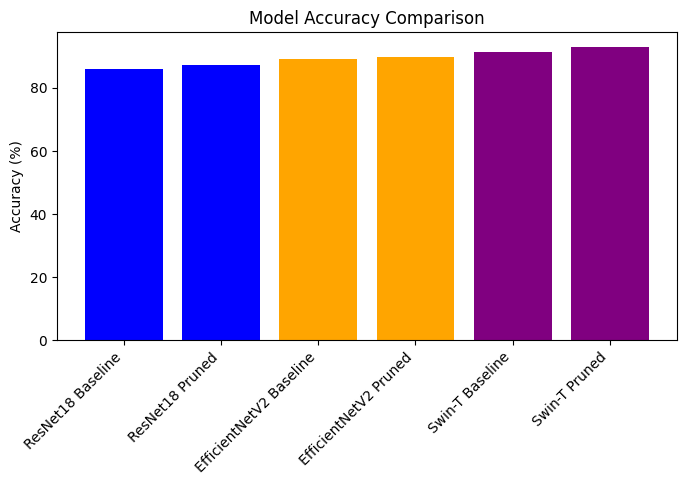

In [ ]:
#Compare the performance of the baseline and pruned models.
# accuracies
plt.figure(figsize=(8, 4))
plt.bar(accuracies.keys(), accuracies.values(), color=["blue", "blue", "orange", "orange", "purple", "purple"])
plt.xticks(rotation=45, ha='right')
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy Comparison')
plt.show()

# 4. Model Size and Inference Time

Model Sizes: {'ResNet18 Baseline': 42.71021556854248, 'ResNet18 Pruned': 28.465806653176735, 'EfficientNetV2 Baseline': 77.79599666595459, 'EfficientNetV2 Pruned': 54.307522057434944, 'Swin-T Baseline': 105.04157638549805, 'Swin-T Pruned': 72.57733330296917}
Model inference times: {'ResNet18 Baseline': 14.521188259124756, 'ResNet18 Pruned': 9.856938471783737, 'EfficientNetV2 Baseline': 17.360616445541382, 'EfficientNetV2 Pruned': 12.153545888071498, 'Swin-T Baseline': 18.847671270370483, 'Swin-T Pruned': 13.02235334501256}


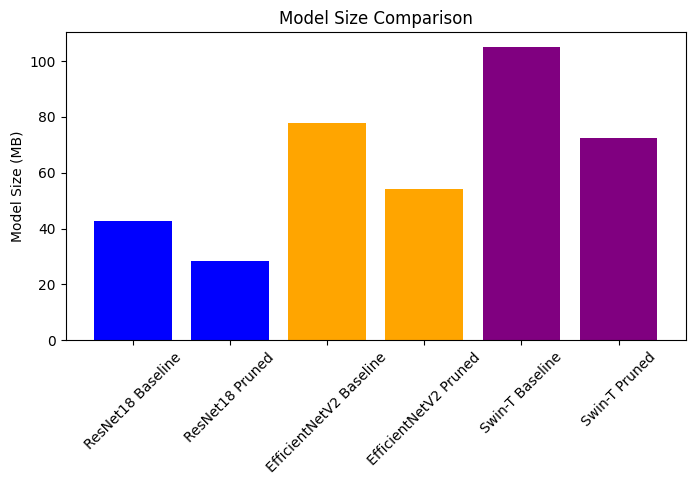

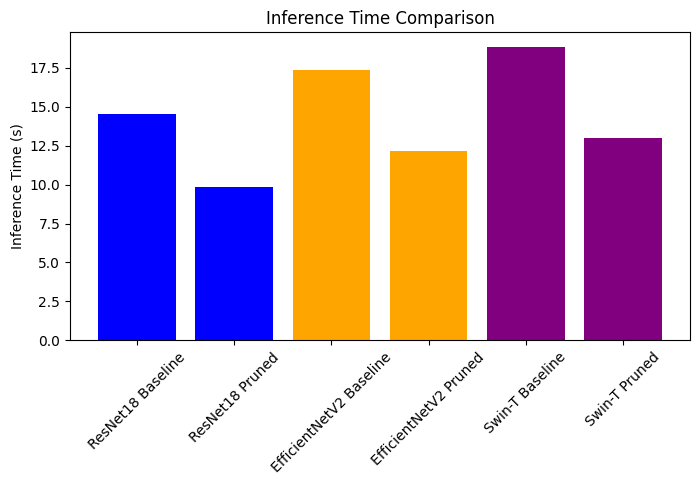

In [ ]:
import time
#Evaluate the model size and inference time for each model.
def get_model_size(model):
    torch.save(model.state_dict(), "temp.p")
    size = os.path.getsize("temp.p") / (1024 * 1024)
    os.remove("temp.p")
    return size

def evaluate_inference_time(model, dataloader):
    model.eval()
    start_time = time.time()
    with torch.no_grad():
        for inputs, _ in dataloader:
            inputs = inputs.to(device)
            _ = model(inputs)
    inference_time = time.time() - start_time
    return inference_time

model_sizes = {}
inference_times = {}

for name, model in models.items():
    model_sizes[name] = get_model_size(model)
    inference_times[name] = evaluate_inference_time(model, test_loader)

print("Model Sizes:", model_sizes)
print("Model inference times:", inference_times)

# model sizes
plt.figure(figsize=(8,4))
plt.bar(model_sizes.keys(), model_sizes.values(), color=["blue", "blue", "orange", "orange", "purple", "purple"])
plt.xticks(rotation=45)
plt.ylabel('Model Size (MB)')
plt.title('Model Size Comparison')
plt.show()

# inference times
plt.figure(figsize=(8,4))
plt.bar(inference_times.keys(), inference_times.values(), color=["blue", "blue", "orange", "orange", "purple", "purple"])
plt.xticks(rotation=45)
plt.ylabel('Inference Time (s)')
plt.title('Inference Time Comparison')
plt.show()
